In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from __future__ import division, print_function, unicode_literals
import pandas as pd
from pandas.plotting import scatter_matrix
import datetime
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import Imputer
import seaborn as sns
%matplotlib inline

# Creating predictor variable, and cleaning our data

In [138]:
def get_labels(df):
    df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])
    df['signup_date'] = pd.to_datetime(df['signup_date'])
    cutoff_date = datetime.date(2014, 6, 1)
    df[df['last_trip_date'] < cutoff_date]
    df['churn'] = (df['last_trip_date'] < cutoff_date).astype(int)
    df['recent'] = (cutoff_date-df['signup_date']).apply(lambda x: pd.Timedelta(x).days)
    return df
def fill_na(df):
    impute = Imputer()
    df['filled_by_driver'] = df['avg_rating_by_driver'].isnull().astype(int)
    df['filled_of_driver'] = df['avg_rating_of_driver'].isnull().astype(int)
    df[['avg_rating_by_driver','avg_rating_of_driver']] = impute.fit_transform(df[['avg_rating_by_driver','avg_rating_of_driver']]) 
    df['phone_fill'] = df['phone'].isnull().astype(int)
    df = df.fillna(method='ffill')
    return df
def remove_error(df):
    df = df[(df['avg_dist']!=0) | (df['trips_in_first_30_days']==0)]
    df = pd.get_dummies(df,drop_first=True)
    return df

In [139]:
df = (pd.read_csv('data/churn_train.csv')
      .pipe(get_labels)
      .pipe(fill_na)
     .pipe(remove_error)
     .drop(['signup_date','last_trip_date'],axis=1))
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,churn,recent,filled_by_driver,filled_of_driver,phone_fill,city_King's Landing,city_Winterfell,phone_iPhone
0,6.94,5.0,5.000000,1.00,0.0,0,False,100.0,1,140,0,0,0,0,0,0
1,8.06,5.0,5.000000,1.00,0.0,2,True,0.0,1,127,0,0,0,0,0,0
2,21.50,4.0,4.601697,1.00,0.0,1,True,100.0,1,150,0,1,0,0,1,1
3,9.46,5.0,4.601697,2.75,100.0,1,False,100.0,1,143,0,1,0,0,1,0
4,13.77,5.0,4.601697,1.00,0.0,0,False,100.0,1,121,0,1,0,0,1,1


In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39921 entries, 0 to 39999
Data columns (total 12 columns):
avg_dist                  39921 non-null float64
avg_rating_by_driver      39921 non-null float64
avg_rating_of_driver      39921 non-null float64
avg_surge                 39921 non-null float64
city                      39921 non-null object
phone                     39921 non-null object
surge_pct                 39921 non-null float64
trips_in_first_30_days    39921 non-null int64
luxury_car_user           39921 non-null bool
weekday_pct               39921 non-null float64
churn                     39921 non-null int64
recent                    39921 non-null int64
dtypes: bool(1), float64(6), int64(3), object(2)
memory usage: 3.7+ MB


In [54]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
avg_dist,39921.0,5.802762,5.707879,0.0,2.43,3.89,6.93,160.96
avg_rating_by_driver,39921.0,4.778571,0.442870,1.0,4.70,5.00,5.00,5.00
avg_rating_of_driver,39921.0,4.601969,0.561776,1.0,4.50,4.70,5.00,5.00
avg_surge,39921.0,1.074998,0.222274,1.0,1.00,1.00,1.05,8.00
surge_pct,39921.0,8.867356,20.014482,0.0,0.00,0.00,8.50,100.00
trips_in_first_30_days,39921.0,2.283184,3.814642,0.0,0.00,1.00,3.00,125.00
weekday_pct,39921.0,60.877115,37.061966,0.0,33.30,66.70,100.00,100.00
churn,39921.0,0.623531,0.484506,0.0,0.00,1.00,1.00,1.00
recent,39921.0,135.460209,8.750126,121.0,128.00,135.00,143.00,151.00


# Exploring continuous variables

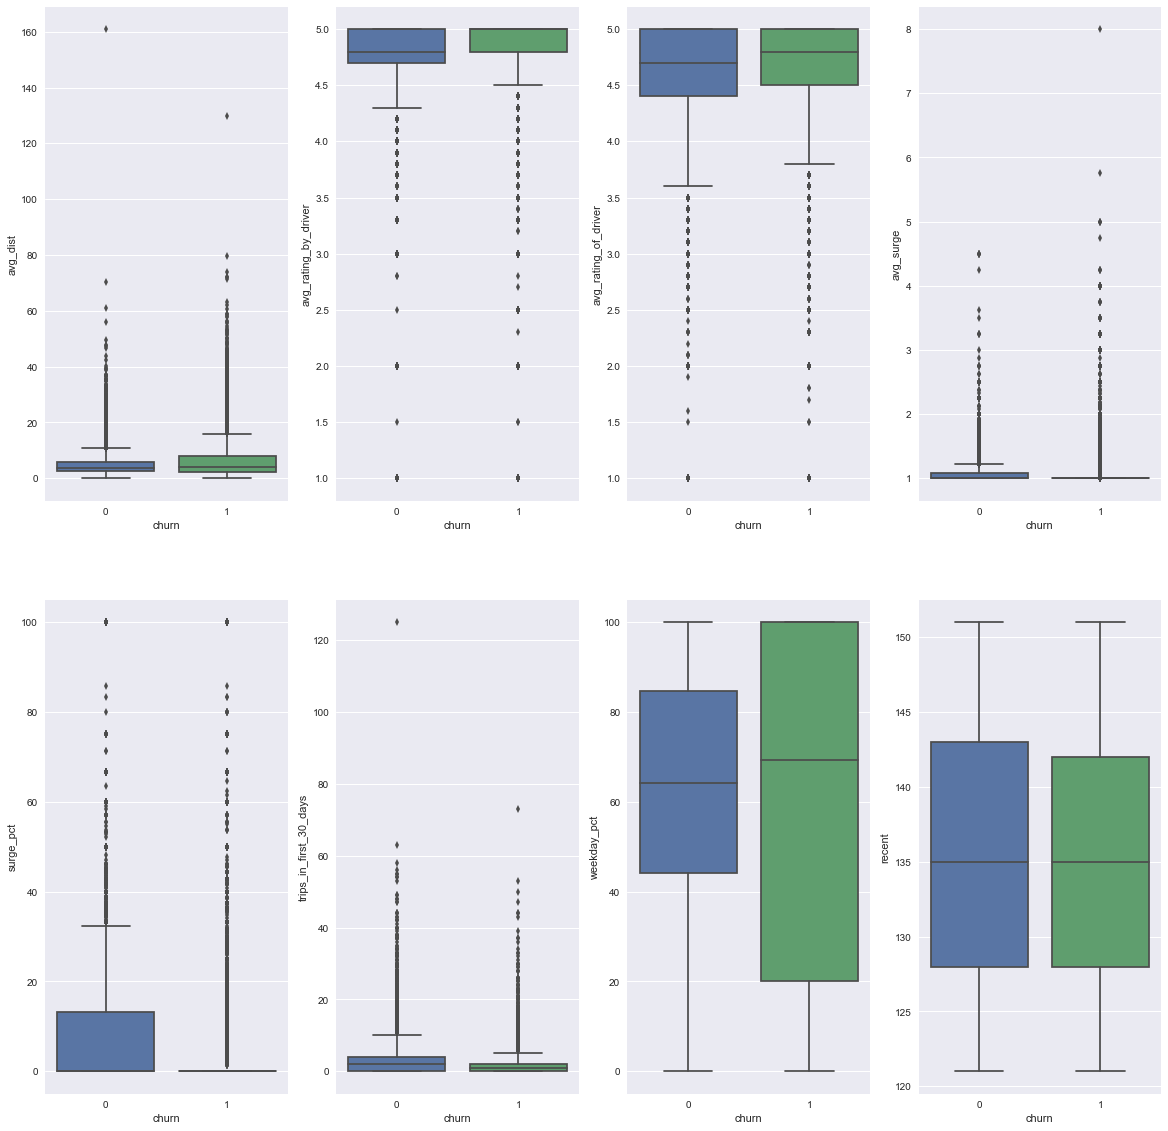

In [72]:
fig = plt.figure(figsize = (20,20))
index = 0
columns = ['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge', 'surge_pct', 'trips_in_first_30_days', 'weekday_pct','recent']
for column in columns:
        index += 1
        ax = fig.add_subplot(2,4,index)
        sns.boxplot(df['churn'],df[column])
plt.show()


The only interesting points are churn against weekday_pct

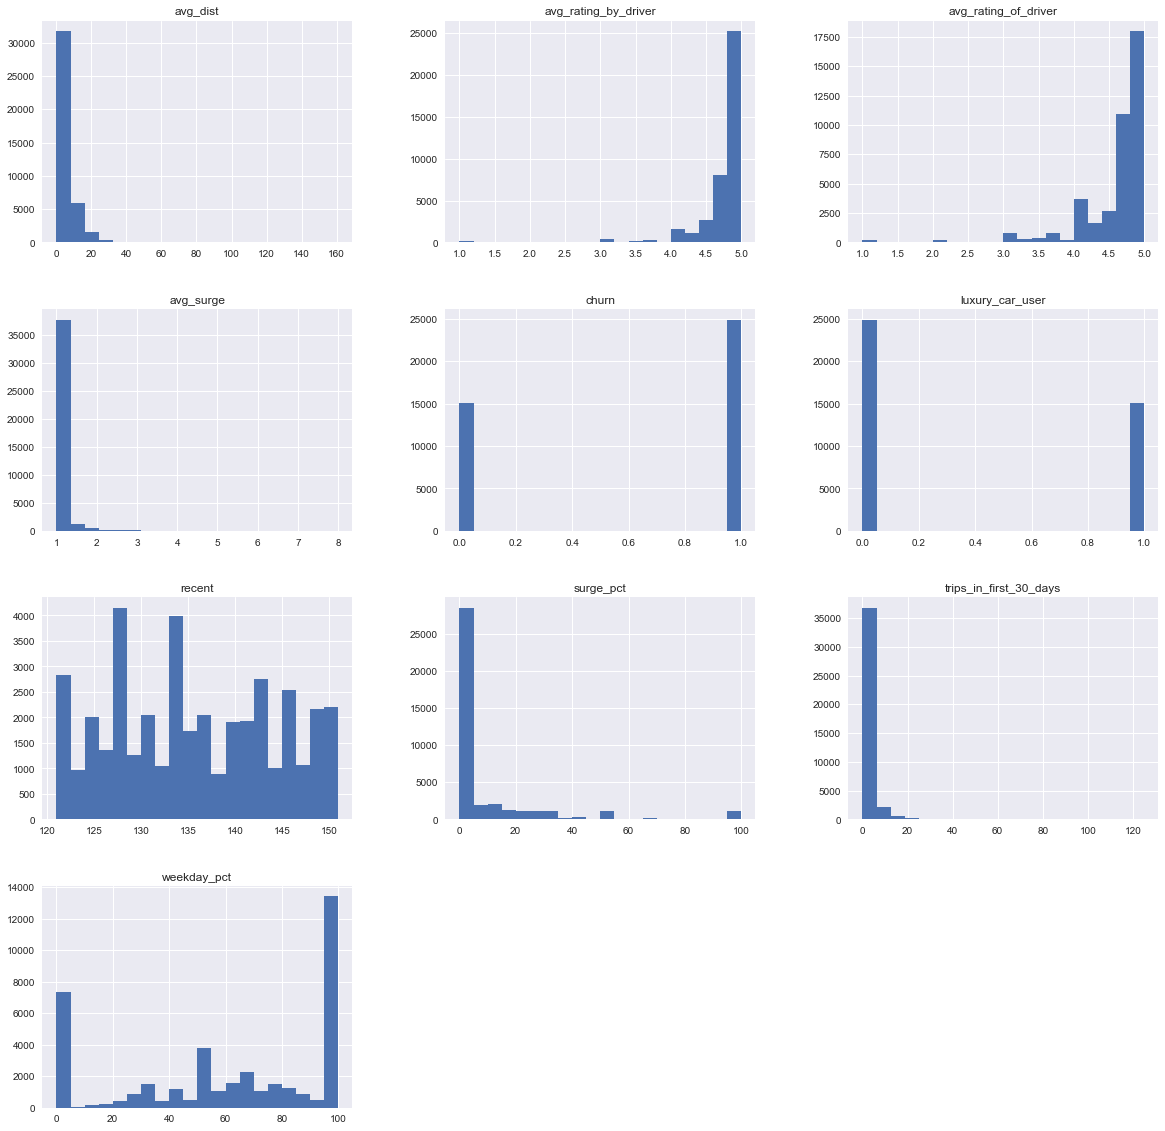

In [77]:
df.hist(figsize=(20,20), bins=20)
plt.show()

See how our varialbes are distributed

In [82]:
df.corr()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,churn,recent
avg_dist,1.000000,0.079725,0.030053,-0.079894,-0.103061,-0.136042,0.024780,0.097639,0.094928,-0.017205
avg_rating_by_driver,0.079725,1.000000,0.097345,0.008293,0.018731,-0.040560,0.009221,0.020196,0.029801,-0.000504
avg_rating_of_driver,0.030053,0.097345,1.000000,-0.027999,-0.008978,-0.013624,0.001152,0.010361,0.012465,-0.007151
avg_surge,-0.079894,0.008293,-0.027999,1.000000,0.793590,-0.001913,-0.075889,-0.113134,0.003421,0.008897
surge_pct,-0.103061,0.018731,-0.008978,0.793590,1.000000,0.004556,-0.104146,-0.148122,-0.010991,0.001587
trips_in_first_30_days,-0.136042,-0.040560,-0.013624,-0.001913,0.004556,1.000000,0.114472,0.049802,-0.210353,-0.014487
luxury_car_user,0.024780,0.009221,0.001152,-0.075889,-0.104146,0.114472,1.000000,0.033848,-0.206363,0.004152
weekday_pct,0.097639,0.020196,0.010361,-0.113134,-0.148122,0.049802,0.033848,1.000000,-0.008321,-0.003754
churn,0.094928,0.029801,0.012465,0.003421,-0.010991,-0.210353,-0.206363,-0.008321,1.000000,-0.019272
recent,-0.017205,-0.000504,-0.007151,0.008897,0.001587,-0.014487,0.004152,-0.003754,-0.019272,1.000000


We notice luxury_car_user and trips_in_first_30_days contain the highest correlation against churn. Although the values we observed here are continuous variables, it would make much more sense if we made them categorical.

# Exploring Categorical

In [91]:
def convert_weekday(row):
    if row['weekday_pct'] == 0:
        return 'only_weekend'
    elif row['weekday_pct'] == 100:
        return 'all_weekdays' 
    else:
        return 'in_between'

In [96]:
df['weekday'] = df.apply(convert_weekday,axis=1)

In [97]:
df['30_days'] = df['trips_in_first_30_days'] > 0

In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39921 entries, 0 to 39999
Data columns (total 16 columns):
avg_dist                  39921 non-null float64
avg_rating_by_driver      39921 non-null float64
avg_rating_of_driver      39921 non-null float64
avg_surge                 39921 non-null float64
city                      39921 non-null object
phone                     39921 non-null object
surge_pct                 39921 non-null float64
trips_in_first_30_days    39921 non-null int64
luxury_car_user           39921 non-null bool
weekday_pct               39921 non-null float64
churn                     39921 non-null int64
recent                    39921 non-null int64
weekend_only              39921 non-null bool
weekday_only              39921 non-null bool
weekday                   39921 non-null object
30_days                   39921 non-null bool
dtypes: bool(4), float64(6), int64(3), object(3)
memory usage: 5.4+ MB


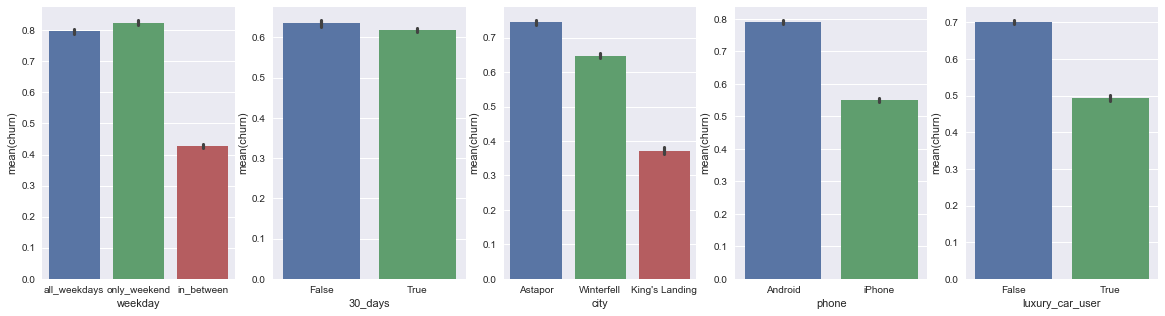

In [99]:
fig = plt.figure(figsize = (20,5))
index = 0
columns = ['weekday','30_days', 'city', 'phone', 'luxury_car_user']
for column in columns:
    index += 1
    ax = fig.add_subplot(1,5, index)
    sns.barplot(x = column, y = "churn", data = df,ax=ax)
plt.show()

from this plot we notice drivers who drive paritially on weekends and weekdays don't churn as much, similary non-luxury cars, android users, and people from King's landing are less likely to churn

# We further explore our data with the help of RandomForest selectors

In [103]:
df = pd.get_dummies(df,drop_first=True)

In [105]:
rand_f = RandomForestClassifier()

In [108]:
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,recent,weekend_only,weekday_only,30_days,city_King's Landing,city_Winterfell,phone_iPhone,weekday_in_between,weekday_only_weekend
0,6.94,5.0,5.000000,1.00,0.0,0,False,100.0,140,True,True,False,0,0,0,0,0
1,8.06,5.0,5.000000,1.00,0.0,2,True,0.0,127,False,False,True,0,0,0,0,1
2,21.50,4.0,4.601697,1.00,0.0,1,True,100.0,150,True,True,True,0,1,1,0,0
3,9.46,5.0,4.601697,2.75,100.0,1,False,100.0,143,True,True,True,0,1,0,0,0
4,13.77,5.0,4.601697,1.00,0.0,0,False,100.0,121,True,True,False,0,1,1,0,0


In [109]:
y = df.pop('churn').values

array([1, 1, 1, ..., 0, 1, 0])

In [128]:
df = df[['avg_dist','recent','avg_rating_by_driver','avg_rating_of_driver',"city_King's Landing",
       'surge_pct','avg_surge','phone_iPhone', 'luxury_car_user',
       'city_Winterfell','30_days','weekday_only_weekend','weekday_in_between']]

In [129]:
X = df.values

In [130]:
rand_f.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [131]:
sorted(zip(rand_f.feature_importances_,df.columns),reverse=True)

[(0.25502005792684923, 'avg_dist'),
 (0.1589775436076469, u'recent'),
 (0.11760737420457704, 'avg_rating_by_driver'),
 (0.088047726239885118, 'surge_pct'),
 (0.083022589227516444, 'avg_rating_of_driver'),
 (0.061303814160641165, 'avg_surge'),
 (0.060588173658065472, "city_King's Landing"),
 (0.052565996609448794, u'weekday_in_between'),
 (0.037601212707734886, 'phone_iPhone'),
 (0.030715470102713298, 'luxury_car_user'),
 (0.024728590645943443, u'30_days'),
 (0.014918313094499969, u'weekday_only_weekend'),
 (0.014903137814478301, 'city_Winterfell')]

# Conclusion

From the categorical features we notice, users who only ride on weekends or weedays churn more often than users who seem to use it everyday. We also see users in kings landing are less likely to churn than other cities, and users with iphones churn slightly less. Possible explanations for this include, users who use the app on both weekdays and weekends uses the car-riding service as their primary form of transportation. People in King's Landing might require the app more, due to geographical reasons. The app might have better comptability with Iphone.

When we include continuous features, average distance seems like a possible avenue to explore. From the histograms, there seems to be a lot of short average distances. One avenue to explore with more time, is to bin distances and create barplots for each bin, similar to what we did for weekday percentage